In [9]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
all_data = pd.read_csv("pasajeros_actualizado.csv")
all_inputs = all_data.iloc[:, 0:16].values
all_outputs = all_data.iloc[:, -1].values
scaler = StandardScaler()
all_inputs = scaler.fit_transform(all_inputs)

X_train, X_test, Y_train, Y_test = train_test_split(all_inputs, all_outputs, test_size=1 / 3)
n = X_train.shape[0]

relu = lambda x: np.maximum(x, 0) 
logistic = lambda x: 1 / (1 + np.exp(-x))

np.random.seed(79)
w_hidden = np.random.rand(12, 16)
w_hidden2 = np.random.rand(8, 12)         
w_output = np.random.rand(1, 8)  

b_hidden = np.random.rand(12, 1)  
b_hidden2 = np.random.rand(8, 1)    
b_output = np.random.rand(1, 1)    

def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden     
    A1 = relu(Z1)                    
    Z2 = w_hidden2 @ A1 + b_hidden2    
    A2 = relu(Z2)                    
    Z3 = w_output @ A2 + b_output 
    A3 = logistic(Z3)                
    return Z1, A1, Z2, A2, Z3, A3

L = 0.01

d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    dC_dA3 = 2 * (A3 - Y)           
    dA3_dZ3 = d_logistic(Z3)
    dZ3_dW3 = A2
    dZ3_dA2 = w_output
    dC_dZ3 = dC_dA3 * dA3_dZ3  

    dC_dA2 = dZ3_dA2.T @ dC_dZ3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dA1 = w_hidden2
    dC_dZ2 = dC_dA2 * dA2_dZ2

    dC_dA1 = dZ2_dA1.T @ dC_dZ2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dC_dZ1 = dC_dA1 * dA1_dZ1

    dC_dW3 = dC_dZ3 @ dZ3_dW3.T
    dC_dB3 = np.sum(dC_dZ3, axis=1, keepdims=True)  

    dC_dW2 = dC_dZ2 @ dZ2_dW2.T
    dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)

    dC_dW1 = dC_dZ1 @ dZ1_dW1.T
    dC_dB1 = np.sum(dC_dZ1, axis=1, keepdims=True)
    
    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3

accuracy_train_l = []
accuracy_test_l = []

for i in tqdm(range(150_000)):
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_hidden2 -= L * dW2
    b_hidden2 -= L * dB2
    w_output -= L * dW3
    b_output -= L * dB3
    
    train_predictions = forward_prop(X_train.transpose())[5]  # Obtener A3 para el conjunto de entrenamiento
    train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)
    accuracy_train = sum(train_comparisons.astype(int)) / X_train.shape[0]
    accuracy_train_l.append(accuracy_train)

    test_predictions = forward_prop(X_test.transpose())[5]  # Obtener A3 para el conjunto de prueba
    test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
    accuracy_test = sum(test_comparisons.astype(int)) / X_test.shape[0]
    accuracy_test_l.append(accuracy_test)

print("X_train ACCURACY post training: ", accuracy_train)
print("X_test ACCURACY post training: ", accuracy_test)

100%|██████████| 150000/150000 [09:53<00:00, 252.61it/s]

X_train ACCURACY post training:  0.9334757752497546
X_test ACCURACY post training:  0.9342880240212496


<function matplotlib.pyplot.show(close=None, block=None)>

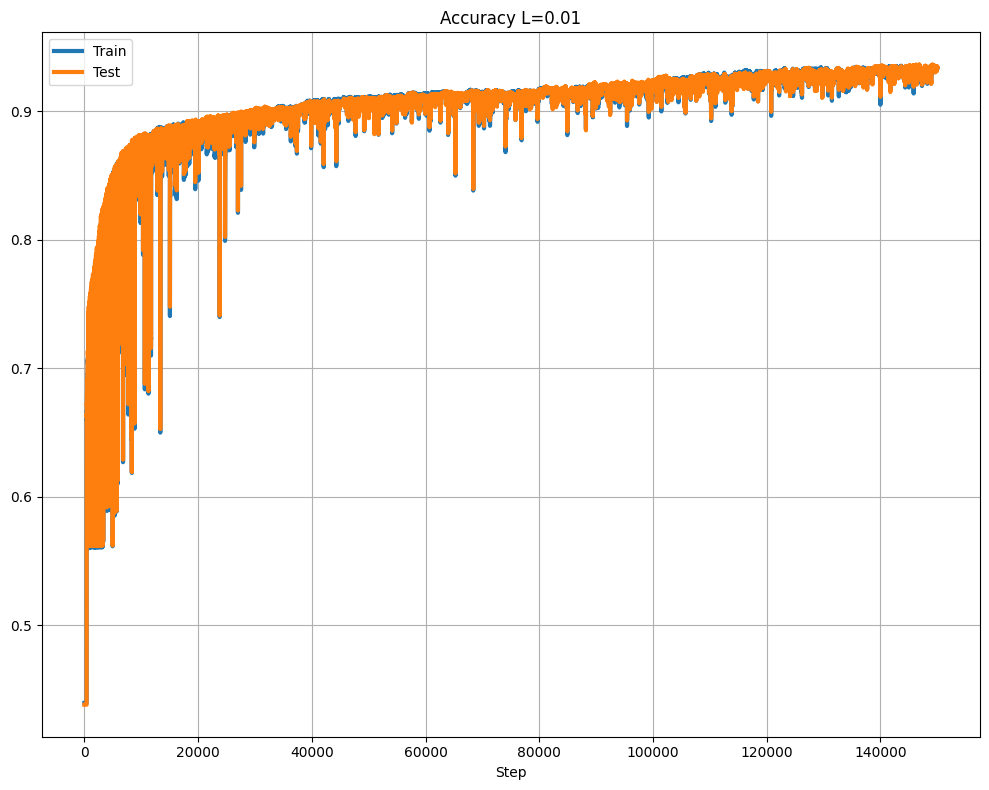

In [15]:
import matplotlib.pyplot as plt

fnt_train = {
    'color': 'tab:blue',
    'ls': 'solid',
    'lw': 3
}

fnt_test = {
    'color': 'tab:orange',
    'ls': 'solid',
    'lw': 3
}

fig, (ax) = plt.subplots(1,1,figsize=(10,8))

ax.plot(accuracy_train_l, label='Train', **fnt_train)
ax.plot(accuracy_test_l, label='Test', **fnt_test)

ax.grid(which='both')
ax.legend()
ax.set_title(f'Accuracy {L=}')
ax.set_xlabel('Step')

fig.tight_layout()
plt.show

In [22]:
import matplotlib.pyplot as plt

def graficar_accuracy(L, train_l, test_l):
    iters = len(test_l)
    fnt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3
    }

    fnt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3
    }

    fig, (ax) = plt.subplots(1,1,figsize=(10,8))

    ax.plot(train_l, label='Train', **fnt_train)
    ax.plot(test_l, label='Test', **fnt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy {L=}')
    ax.set_xlabel('Step')

    fig.tight_layout()
    plt.savefig(f'accuracy_{L=}_{iters=}.png')

In [23]:
def mi_red_neuronal(L,iters):
    relu = lambda x: np.maximum(x, 0) 
    logistic = lambda x: 1 / (1 + np.exp(-x))

    np.random.seed(0)
    w_hidden = np.random.rand(12, 16)
    w_hidden2 = np.random.rand(8, 12)         
    w_output = np.random.rand(1, 8)  

    b_hidden = np.random.rand(12, 1)  
    b_hidden2 = np.random.rand(8, 1)    
    b_output = np.random.rand(1, 1)    

    def forward_prop(X):
        Z1 = w_hidden @ X + b_hidden     
        A1 = relu(Z1)                    
        Z2 = w_hidden2 @ A1 + b_hidden2    
        A2 = relu(Z2)                    
        Z3 = w_output @ A2 + b_output 
        A3 = logistic(Z3)                
        return Z1, A1, Z2, A2, Z3, A3

    d_relu = lambda x: x > 0
    d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
        dC_dA3 = 2 * (A3 - Y)           
        dA3_dZ3 = d_logistic(Z3)
        dZ3_dW3 = A2
        dZ3_dA2 = w_output
        dC_dZ3 = dC_dA3 * dA3_dZ3  

        dC_dA2 = dZ3_dA2.T @ dC_dZ3
        dA2_dZ2 = d_relu(Z2)
        dZ2_dW2 = A1
        dZ2_dA1 = w_hidden2
        dC_dZ2 = dC_dA2 * dA2_dZ2

        dC_dA1 = dZ2_dA1.T @ dC_dZ2
        dA1_dZ1 = d_relu(Z1)
        dZ1_dW1 = X
        dC_dZ1 = dC_dA1 * dA1_dZ1

        dC_dW3 = dC_dZ3 @ dZ3_dW3.T
        dC_dB3 = np.sum(dC_dZ3, axis=1, keepdims=True)  

        dC_dW2 = dC_dZ2 @ dZ2_dW2.T
        dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)

        dC_dW1 = dC_dZ1 @ dZ1_dW1.T
        dC_dB1 = np.sum(dC_dZ1, axis=1, keepdims=True)
        
        return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3

    accuracy_train_l = []
    accuracy_test_l = []

    for i in tqdm(range(iters)):
        idx = np.random.choice(n, 1, replace=False)
        X_sample = X_train[idx].transpose()
        Y_sample = Y_train[idx]

        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

        dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

        w_hidden -= L * dW1
        b_hidden -= L * dB1
        w_hidden2 -= L * dW2
        b_hidden2 -= L * dB2
        w_output -= L * dW3
        b_output -= L * dB3
        
        train_predictions = forward_prop(X_train.transpose())[5]  # Obtener A3 para el conjunto de entrenamiento
        train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)
        accuracy_train = sum(train_comparisons.astype(int)) / X_train.shape[0]
        accuracy_train_l.append(accuracy_train)

        test_predictions = forward_prop(X_test.transpose())[5]  # Obtener A3 para el conjunto de prueba
        test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
        accuracy_test = sum(test_comparisons.astype(int)) / X_test.shape[0]
        accuracy_test_l.append(accuracy_test)

    graficar_accuracy(L=L, train_l=accuracy_train_l,test_l=accuracy_test_l)

100%|██████████| 300/300 [00:01<00:00, 297.08it/s]


100%|██████████| 300/300 [00:00<00:00, 335.19it/s]


100%|██████████| 300/300 [00:00<00:00, 347.63it/s]


100%|██████████| 300/300 [00:00<00:00, 348.43it/s]


100%|██████████| 3000/3000 [00:07<00:00, 385.66it/s]


100%|██████████| 3000/3000 [00:08<00:00, 366.74it/s]


100%|██████████| 3000/3000 [00:07<00:00, 379.70it/s]


100%|██████████| 3000/3000 [00:07<00:00, 385.88it/s]


100%|██████████| 30000/30000 [01:17<00:00, 387.80it/s]


100%|██████████| 30000/30000 [01:18<00:00, 384.18it/s]


100%|██████████| 30000/30000 [01:16<00:00, 389.91it/s]


100%|██████████| 30000/30000 [01:18<00:00, 382.59it/s]


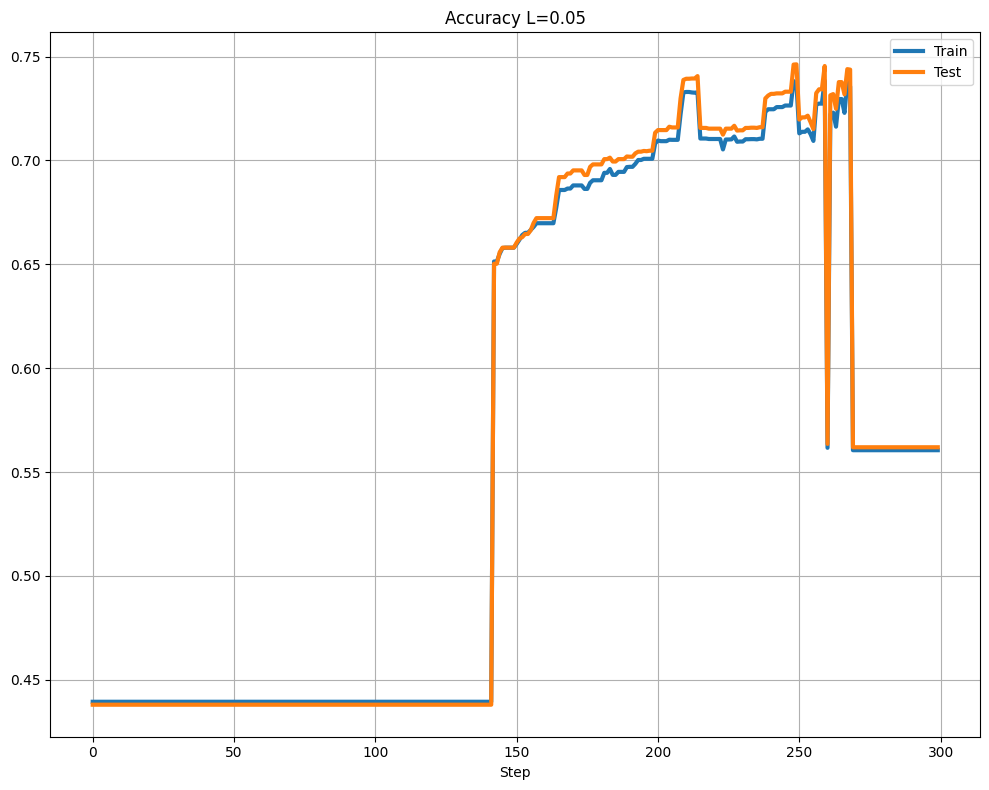

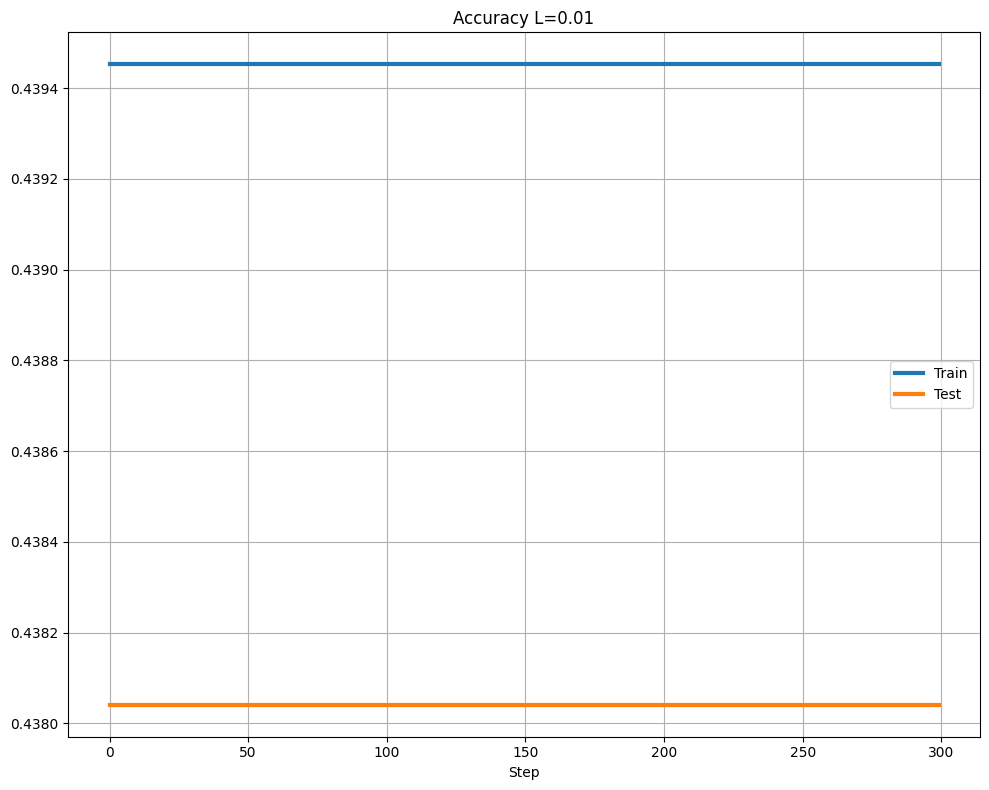

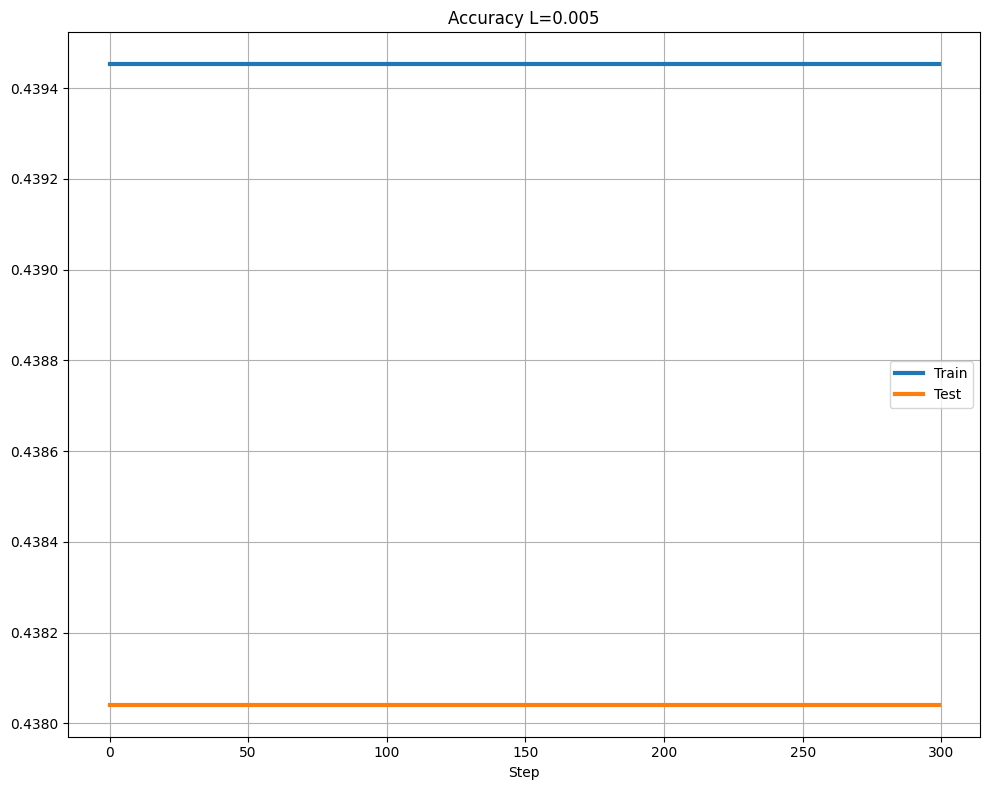

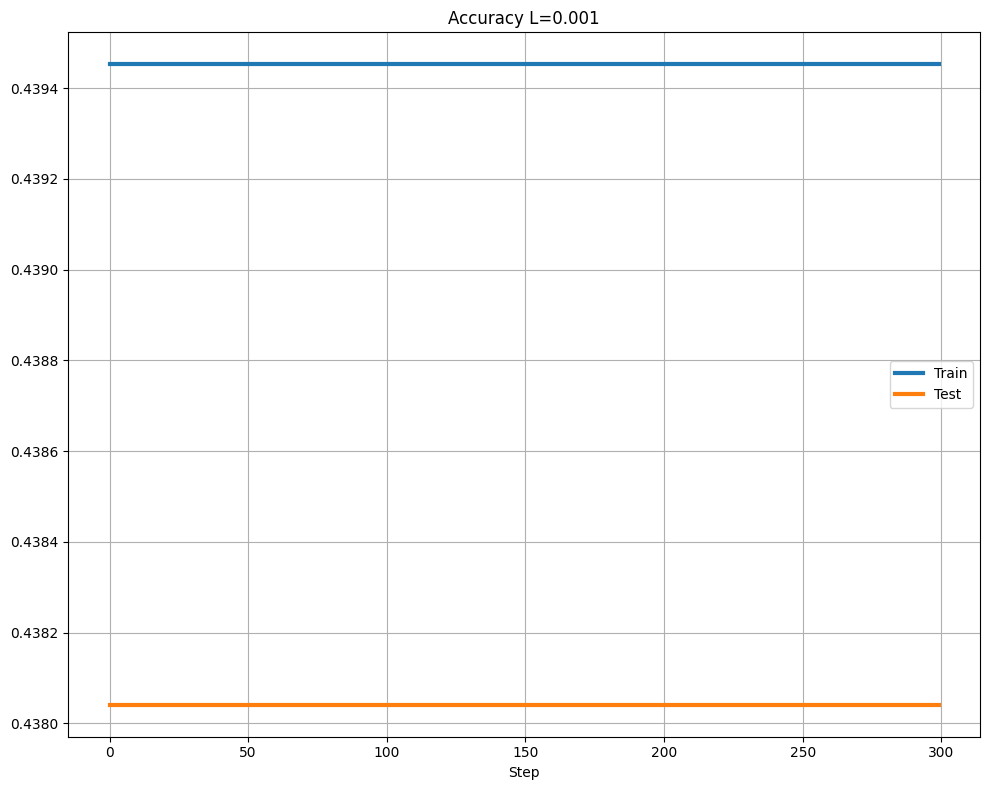

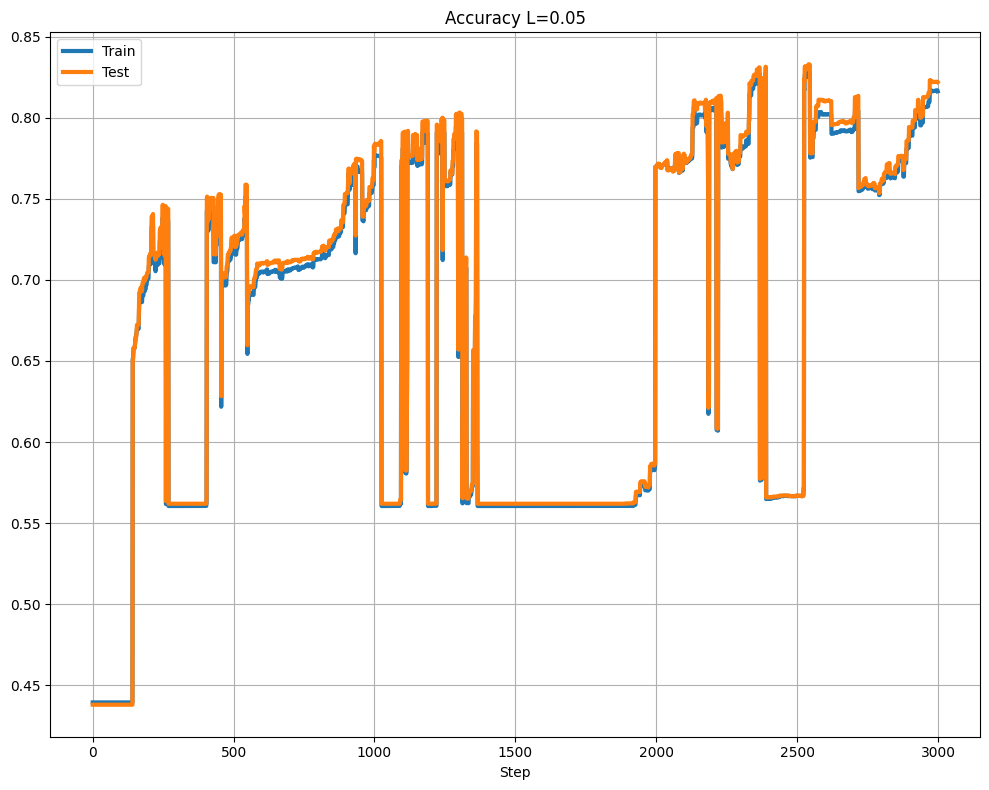

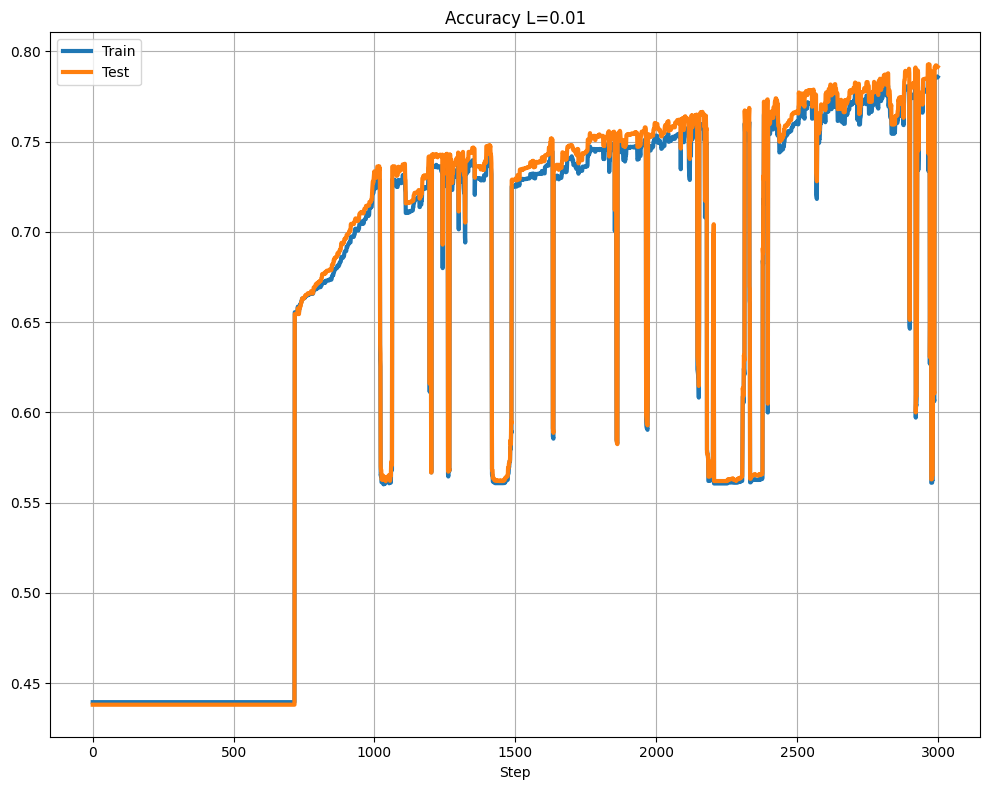

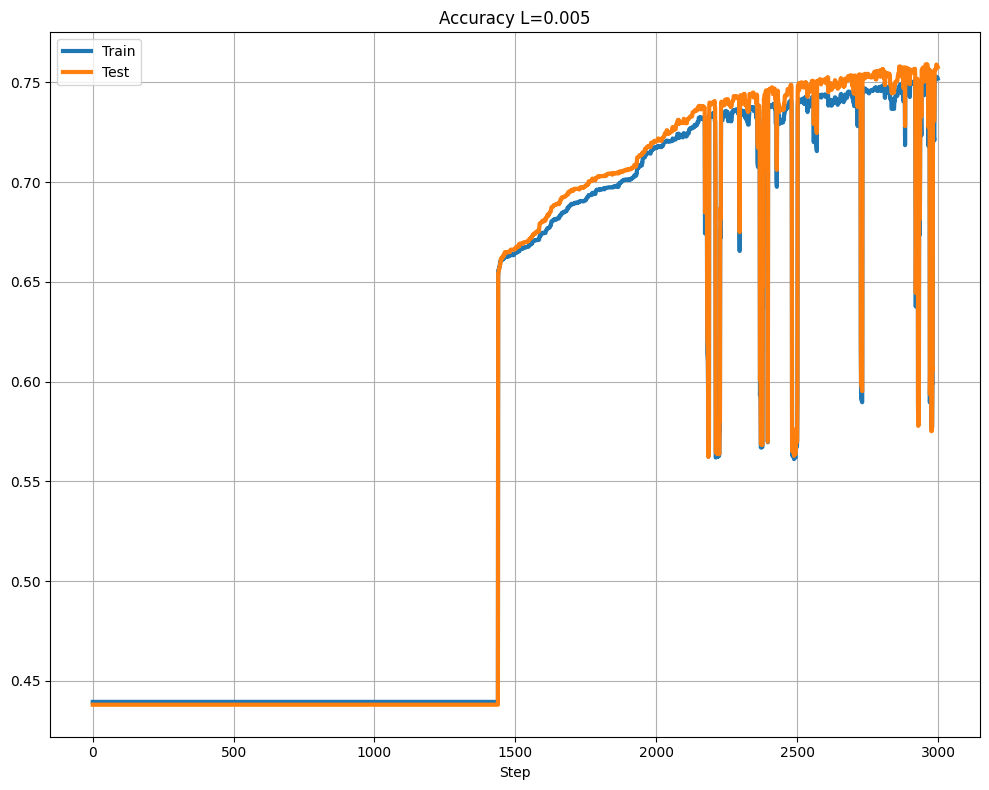

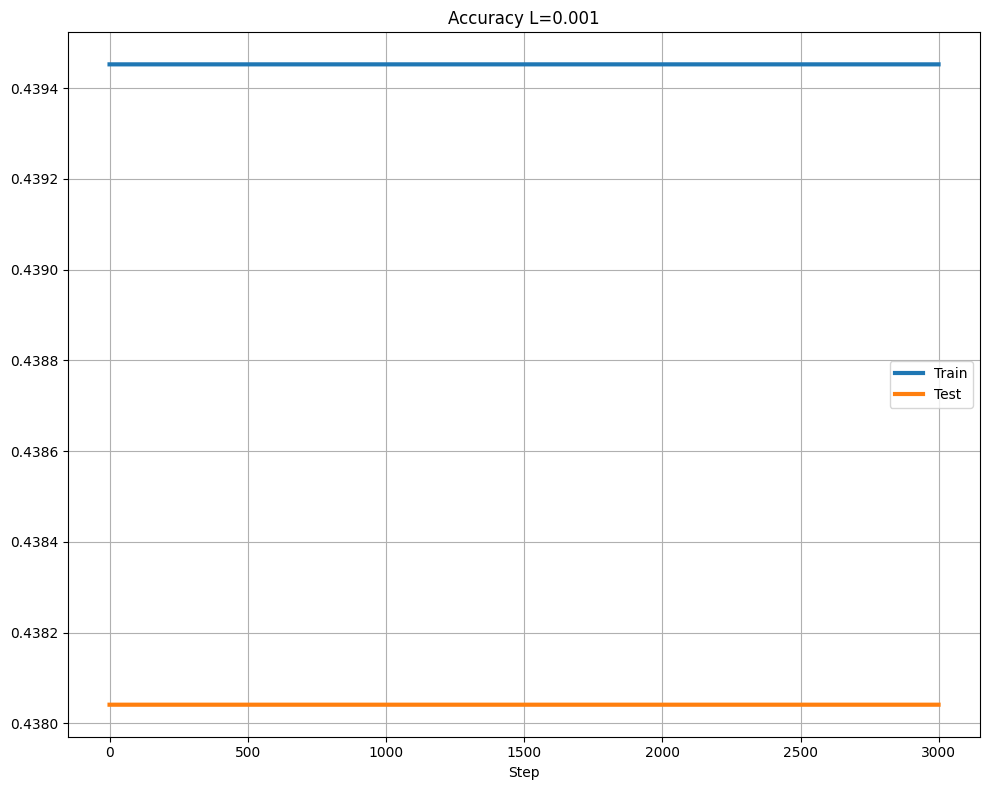

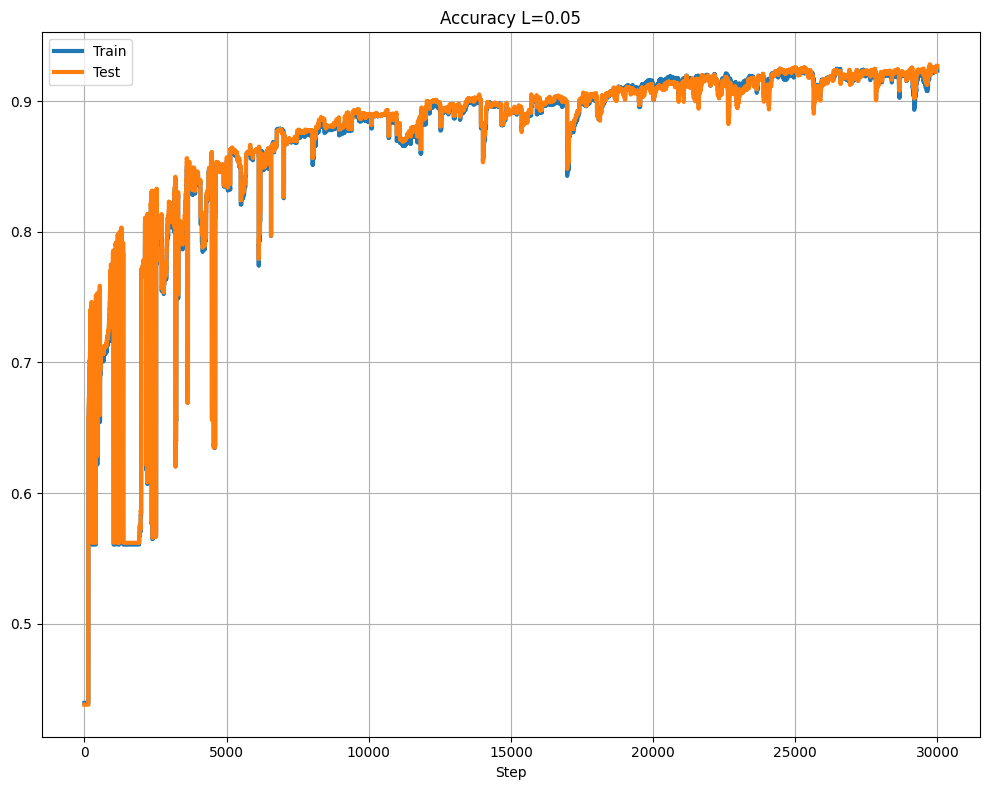

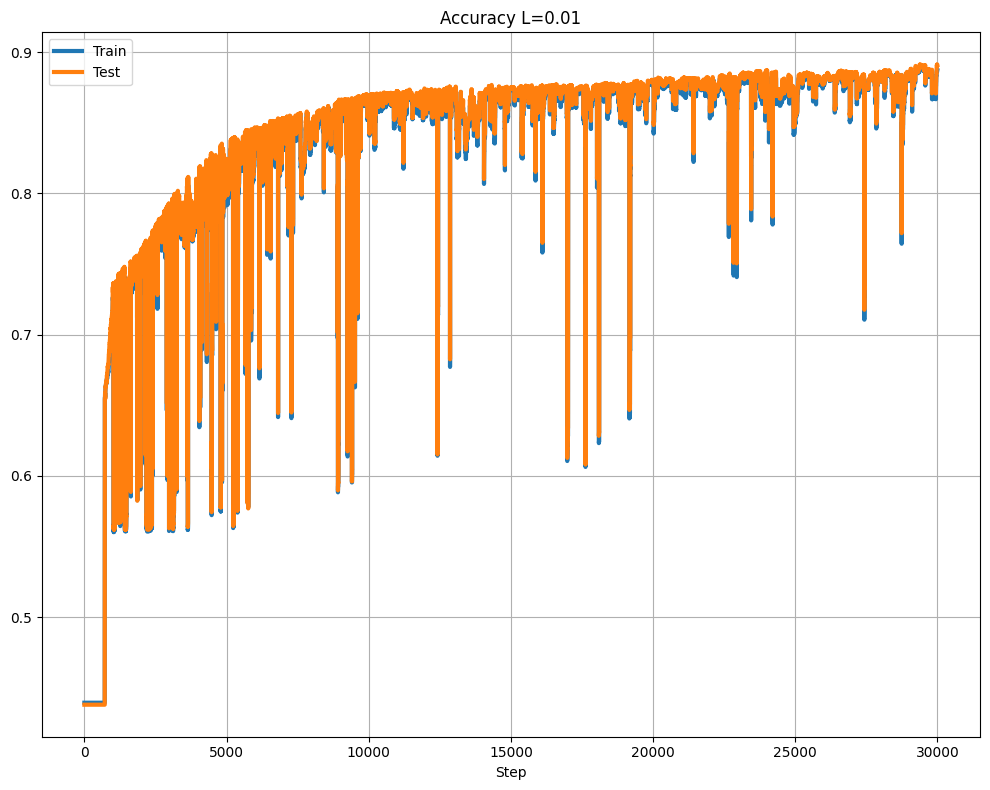

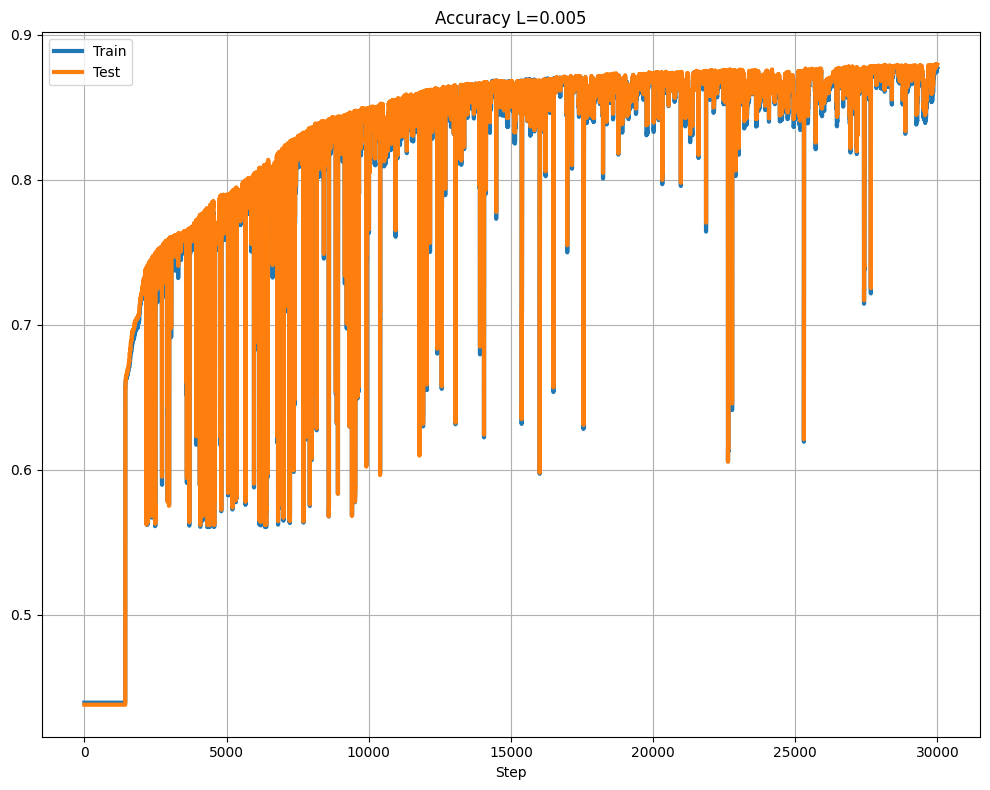

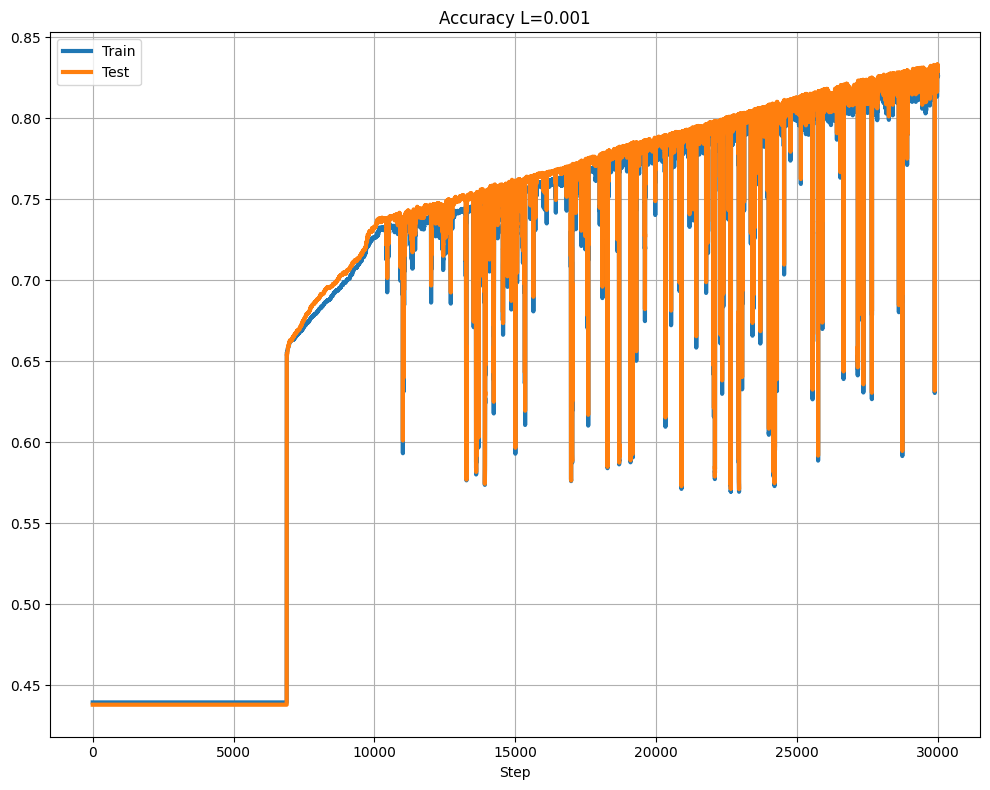

In [24]:
iters_l = (300,3000,30000)
L_l = (0.05, 0.01, 0.005, 0.001)

for iter in iters_l:
    for L in L_l:
        mi_red_neuronal(L=L, iters= iter)
        print()

Observando los gráficos me doy cuenta que con un L de 0.05 a las 30000 iteraciones ya obtengo mas del 0.9 de accuracy y voy a probarlo en mi red neuronal con Scikit-Learn.

In [25]:
import pandas as pd
# cargar datos
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

df = pd.read_csv('pasajeros_actualizado.csv')

# Extraer variables de entrada (todas las filas, todas las columnas menos la última)
# Nota que deberíamos hacer algún escalado lineal aquí
X = (df.values[:, :-1])

# Extraer columna de salida (todas las filas, última columna)
Y = df.values[:, -1]

# Separar los datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

nn = MLPClassifier(solver='adam',
                   hidden_layer_sizes=(12, 8, ),
                   activation='relu',
                   max_iter=30_000,
                   learning_rate_init=.05)

nn.fit(X_train, Y_train)

print("Puntaje del conjunto de entrenamiento: %f" % nn.score(X_train, Y_train))
print("Puntaje del conjunto de prueba: %f" % nn.score(X_test, Y_test))

Puntaje del conjunto de entrenamiento: 0.912340
Puntaje del conjunto de prueba: 0.909343
